In [2]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import random 
import datetime as dt
import re
import pickle
import nltk, warnings
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import digits, punctuation


from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS

warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline


In [3]:
data = pd.read_csv("retailElektra.csv", encoding="ISO-8859-1", dtype={'ClienteID': str,'Factura': str})

In [4]:
data.head(3)

,Factura,SKU,Descripcion,Cantidad,FechaFacturacion,PrecioUnitario,ClienteID,Ciudad
0,536365,85123A,Pantalla LCD Sony 46 Pulgadas HD KDL-46V5100,6,12/1/2010 8:26,2.55,17850,Aguascalientes
1,536365,71053,Prueba Marketplace,6,12/1/2010 8:26,3.39,17850,Aguascalientes
2,536365,84406B,Antena Plana Para Interiores Master TVANTFLATHD,8,12/1/2010 8:26,2.75,17850,Aguascalientes


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300760 entries, 0 to 300759
Data columns (total 8 columns):
Factura             300760 non-null object
SKU                 300760 non-null object
Descripcion         300760 non-null object
Cantidad            300760 non-null int64
FechaFacturacion    300760 non-null object
PrecioUnitario      300760 non-null float64
ClienteID           300760 non-null object
Ciudad              300760 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 18.4+ MB


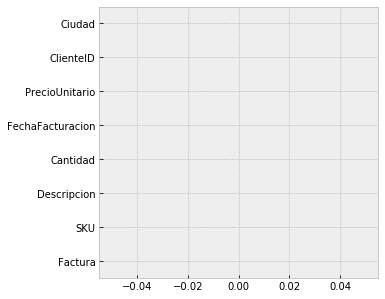

In [6]:
plt.figure(figsize=(5, 5))
data.isnull().mean(axis=0).plot.barh()

In [7]:
nan_rows = data[data.isnull().T.any().T]
nan_rows.head(5)

,Factura,SKU,Descripcion,Cantidad,FechaFacturacion,PrecioUnitario,ClienteID,Ciudad


In [9]:
data = data.dropna(subset=["ClienteID"])

In [10]:
data.drop_duplicates(inplace = True)

In [12]:
data.Ciudad.nunique()

37

In [14]:
cliente_ciudad=data[['Ciudad','ClienteID']].drop_duplicates()
cliente_ciudad.groupby(['Ciudad'])['ClienteID'].aggregate('count').reset_index().sort_values('ClienteID', ascending=False)

,Ciudad,ClienteID
1,Aguascalientes,3924
26,Tapachula,95
28,Tijuana,87
30,Tlalpan,31
0,Acapulco,25
13,Manzanillo,21
4,Celaya,19
17,Mexicali,15
25,San Juan del Rio,12
23,Salina Cruz,11


In [15]:
data.describe()

,Cantidad,PrecioUnitario
count,300760.000000,300760.000000
mean,12.234602,3.614399
std,53.970937,80.181332
min,-9360.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,12540.000000,38970.000000


In [17]:
data[(data['Cantidad']<0)].head(5)

,Factura,SKU,Descripcion,Cantidad,FechaFacturacion,PrecioUnitario,ClienteID,Ciudad
141,C536379,D,Sintonizador de Cable Digital Ghia GAC-002,-1,12/1/2010 9:41,27.50,14527,Aguascalientes
154,C536383,35004C,Pantalla LED Hisense 32 Pulgadas HD 32H3B2,-1,12/1/2010 9:49,4.65,15311,Aguascalientes
235,C536391,22556,Pantalla LED LG 43 Pulgadas Full HD Smart 43LH...,-12,12/1/2010 10:24,1.65,17548,Aguascalientes
236,C536391,21984,Pantalla LED Hisense 40 Pulgadas Full HD Smart...,-24,12/1/2010 10:24,0.29,17548,Aguascalientes
237,C536391,21983,Pantalla LED Phillips 19 Pulgadas HD 19PFL2409/F8,-24,12/1/2010 10:24,0.29,17548,Aguascalientes


In [18]:
temp = data.groupby(by=['ClienteID', 'Factura'], as_index=False)['FechaFacturacion'].count()
nb_products_per_basket = temp.rename(columns = {'FechaFacturacion':'Numero de productos'})

In [20]:
nb_products_per_basket.Factura = nb_products_per_basket.Factura.astype(str)
nb_products_per_basket['ordenCancelada'] = nb_products_per_basket['Factura'].apply(lambda x:int('C' in x))
len(nb_products_per_basket[nb_products_per_basket['ordenCancelada']==1])/len(nb_products_per_basket)*100

14.858996993844539

In [22]:
nb_products_per_basket[nb_products_per_basket['ordenCancelada']==1][:5]

,ClienteID,Factura,Numero de productos,ordenCancelada
21,12352,C545329,2,1
22,12352,C545330,1,1
23,12352,C547388,7,1
37,12359,C549955,2,1
38,12359,C580165,3,1


In [27]:
test = data[data['Cantidad'] < 0][['ClienteID','Cantidad',
                                                   'SKU','Descripcion','PrecioUnitario']]
for index, col in  test.iterrows():
    if data[(data['ClienteID'] == col[0]) & (data['Cantidad'] == -col[1]) 
                & (data['Descripcion'] == col[2])].shape[0] == 0: 
        print(test.loc[index])
        print('Mala hipotesis')
        break

ClienteID                                              14527
Cantidad                                                  -1
SKU                                                        D
Descripcion       Sintonizador de Cable Digital Ghia GAC-002
PrecioUnitario                                          27.5
Name: 141, dtype: object
Mala hipotesis


In [29]:
data[data['ClienteID'] == '14527'].head(5)

,Factura,SKU,Descripcion,Cantidad,FechaFacturacion,PrecioUnitario,ClienteID,Ciudad
141,C536379,D,Sintonizador de Cable Digital Ghia GAC-002,-1,12/1/2010 9:41,27.50,14527,Aguascalientes
6521,537159,22112,Pantalla LED LG 49 Pulgadas Full HD 49LJ5550,6,12/5/2010 13:17,4.95,14527,Aguascalientes
6522,537159,22111,Pantalla LED Hisense 55 Pulgadas 4K Smart 55DU...,1,12/5/2010 13:17,4.95,14527,Aguascalientes
6523,537159,21479,Pantalla LED Hisense 55 Pulgadas Full HD Smart...,1,12/5/2010 13:17,3.75,14527,Aguascalientes
6524,537159,22114,Drone AW-QDR-BPL,6,12/5/2010 13:17,3.95,14527,Aguascalientes


In [30]:
df_cleaned = data.copy(deep = True)
df_cleaned['CantidadCancelada'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  data.iterrows():
    if (col['Cantidad'] > 0) or col['Descripcion'] == 'Discount': continue        
    df_test = data[(data['ClienteID'] == col['ClienteID']) &
                         (data['SKU']  == col['SKU']) & 
                         (data['FechaFacturacion'] < col['FechaFacturacion']) & 
                         (data['Cantidad']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'CantidadCancelada'] = -col['Cantidad']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Cantidad'] < -col['Cantidad']: continue
            df_cleaned.loc[ind, 'CantidadCancelada'] = -col['Cantidad']
            entry_to_remove.append(index) 
            break 

In [32]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 4598
doubtfull_entry: 2136


In [33]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Cantidad'] < 0) & (df_cleaned['SKU'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 30


,Factura,SKU,Descripcion,Cantidad,FechaFacturacion,PrecioUnitario,ClienteID,Ciudad,CantidadCancelada
17400,C538530,22630,Tornamesa Retro Crosley CR8005A-BL Azul,-33,12/13/2010 10:26,1.95,14796,Aguascalientes,0
21976,C539195,22942,Minicomponente Sony Shake X30D,-5,12/16/2010 12:05,8.50,12748,Aguascalientes,0
22169,C539221,22941,Pantalla LED Samsung 24 Pulgadas,-12,12/16/2010 12:56,8.50,14911,Saltillo,0
22170,C539221,22942,Minicomponente Sony Shake X30D,-10,12/16/2010 12:56,8.50,14911,Saltillo,0
47013,C542744,22700,Funda Protectora Easycover para CÃ¡mara Fotogr...,-10,1/31/2011 16:32,0.85,16191,Aguascalientes,0


In [34]:
df_cleaned.drop(remaining_entries.index, axis = 0, inplace = True)

In [35]:
codigo_productos = df_cleaned[df_cleaned['SKU'].str.contains('^[a-zA-Z]+', regex=True)]['SKU'].unique()
codigo_productos

array(['POST', 'C2', 'M', 'BANK CHARGES'], dtype=object)

In [37]:
df_cleaned = df_cleaned[df_cleaned['SKU']!= 'POST']
df_cleaned = df_cleaned[df_cleaned['SKU']!= 'C2']
df_cleaned = df_cleaned[df_cleaned['SKU']!= 'M']
df_cleaned = df_cleaned[df_cleaned['SKU']!= 'BANK CHARGES']

In [38]:
df_cleaned.describe()

,Cantidad,PrecioUnitario,CantidadCancelada
count,292467.000000,292467.000000,292467.000000
mean,12.866204,2.886116,0.187197
std,50.293220,4.255978,9.891721
min,1.000000,0.000000,0.000000
25%,2.000000,1.250000,0.000000
50%,6.000000,1.950000,0.000000
75%,12.000000,3.750000,0.000000
max,12540.000000,295.000000,3114.000000


In [39]:
df_cleaned[(df_cleaned['PrecioUnitario'] == 0)].head(5)

,Factura,SKU,Descripcion,Cantidad,FechaFacturacion,PrecioUnitario,ClienteID,Ciudad,CantidadCancelada
6842,537197,22841,Cabeza de Bola de 1/4 Lume Cube LC-BHMM55,1,12/5/2010 14:02,0.0,12647,Tapachula,0
22612,539263,22580,Bocina Bluetooth Vibe Rojo,4,12/16/2010 14:36,0.0,16560,Aguascalientes,0
25459,539722,22423,CÃ¡mara FotogrÃ¡fica Nikon D7200 Negra,10,12/21/2010 13:45,0.0,14911,Saltillo,0
29173,540372,22090,Bocina Anker A3102H11 - Negro,24,1/6/2011 16:41,0.0,13081,Aguascalientes,0
29175,540372,22553,Pantalla LED Philips 40 Pulgadas Full HD Smart...,24,1/6/2011 16:41,0.0,13081,Aguascalientes,0


In [40]:
def unique_counts(data):
   for i in data.columns:
       count = data[i].nunique()
       print(i, ": ", count)
unique_counts(df_cleaned)

Factura :  17679
SKU :  2312
Descripcion :  2313
Cantidad :  269
FechaFacturacion :  16569
PrecioUnitario :  287
ClienteID :  4303
Ciudad :  37
CantidadCancelada :  98


In [41]:
df_cleaned['PrecioTotal'] = df_cleaned['PrecioUnitario'] * (df_cleaned['Cantidad'] - df_cleaned['CantidadCancelada'])

Text(0.5, 1.0, 'Ingresos por ciudad')

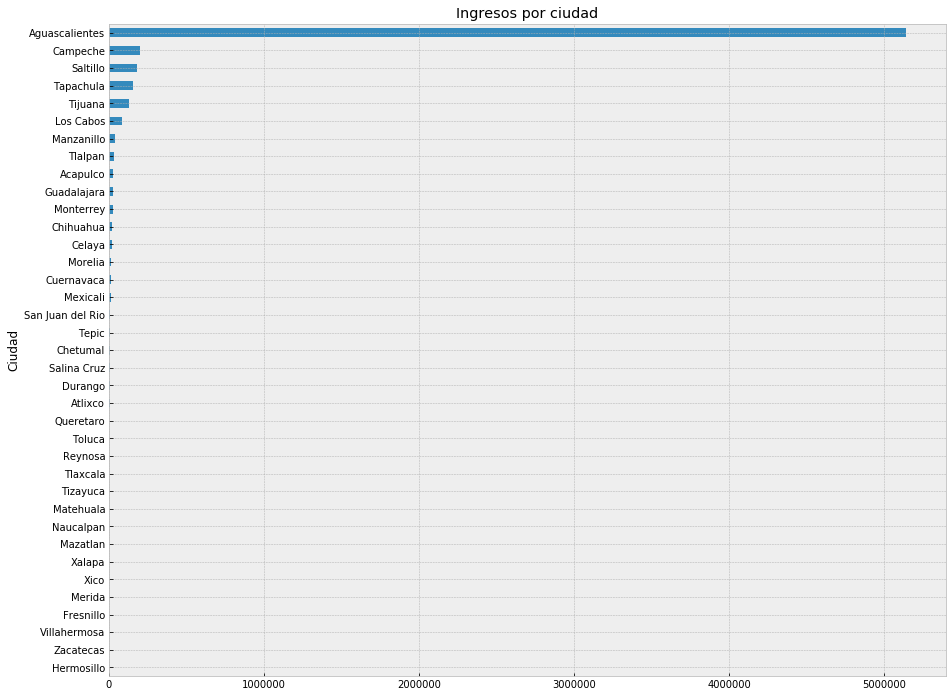

In [43]:
revenue_per_countries = df_cleaned.groupby(["Ciudad"])["PrecioTotal"].sum().sort_values()
revenue_per_countries.plot(kind='barh', figsize=(15,12))
plt.title("Ingresos por ciudad")

Text(0.5, 1.0, 'Total de facturas por ciudad')

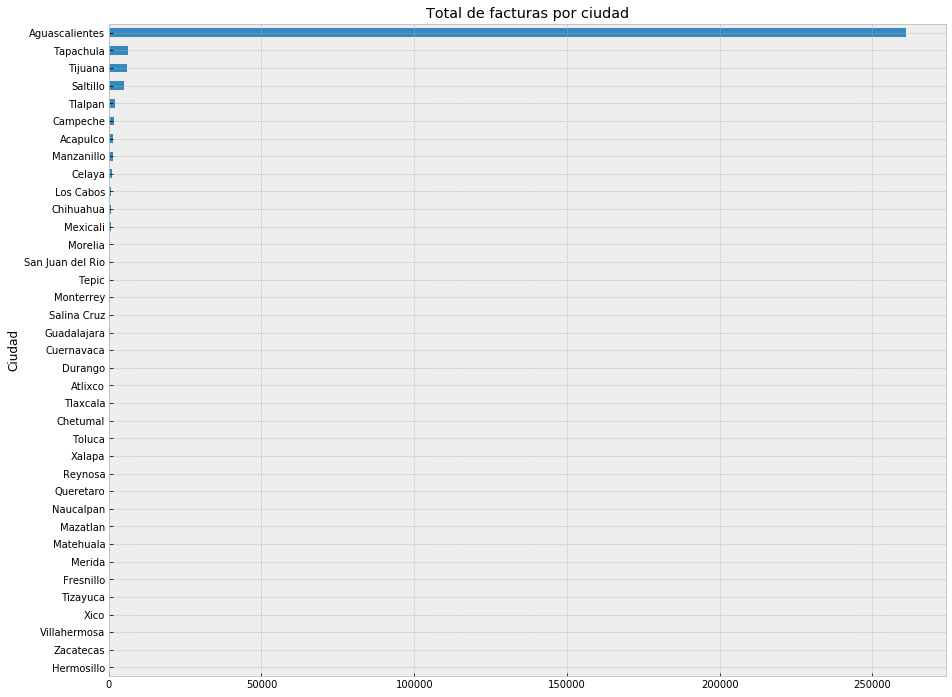

In [44]:
No_invoice_per_country = df_cleaned.groupby(["Ciudad"])["Factura"].count().sort_values()
No_invoice_per_country.plot(kind='barh', figsize=(15,12))
plt.title("Total de facturas por ciudad")

In [45]:
le = LabelEncoder()
le.fit(df_cleaned['Ciudad'])

LabelEncoder()

In [46]:
l = [i for i in range(37)]
dict(zip(list(le.classes_), l))

{'Acapulco': 0,
 'Aguascalientes': 1,
 'Atlixco': 2,
 'Campeche': 3,
 'Celaya': 4,
 'Chetumal': 5,
 'Chihuahua': 6,
 'Cuernavaca': 7,
 'Durango': 8,
 'Fresnillo': 9,
 'Guadalajara': 10,
 'Hermosillo': 11,
 'Los Cabos': 12,
 'Manzanillo': 13,
 'Matehuala': 14,
 'Mazatlan': 15,
 'Merida': 16,
 'Mexicali': 17,
 'Monterrey': 18,
 'Morelia': 19,
 'Naucalpan': 20,
 'Queretaro': 21,
 'Reynosa': 22,
 'Salina Cruz': 23,
 'Saltillo': 24,
 'San Juan del Rio': 25,
 'Tapachula': 26,
 'Tepic': 27,
 'Tijuana': 28,
 'Tizayuca': 29,
 'Tlalpan': 30,
 'Tlaxcala': 31,
 'Toluca': 32,
 'Villahermosa': 33,
 'Xalapa': 34,
 'Xico': 35,
 'Zacatecas': 36}

In [47]:
df_cleaned['Ciudad'] = le.transform(df_cleaned['Ciudad'])


In [48]:
with open('labelencoder.pickle', 'wb') as g:
    pickle.dump(le, g)

In [49]:
df_cleaned['FechaFacturacion'].min()

'1/10/2011 10:32'

In [50]:
df_cleaned['FechaFacturacion'].max()

'9/9/2011 9:52'

In [51]:
NOW = dt.datetime(2011,12,10)
df_cleaned['FechaFacturacion'] = pd.to_datetime(df_cleaned['FechaFacturacion'])

In [52]:
custom_aggregation = {}
custom_aggregation["FechaFacturacion"] = lambda x:x.iloc[0]
custom_aggregation["ClienteID"] = lambda x:x.iloc[0]
custom_aggregation["PrecioTotal"] = "sum"


rfmTable = df_cleaned.groupby("Factura").agg(custom_aggregation)

In [53]:
rfmTable["Recency"] = NOW - rfmTable["FechaFacturacion"]
rfmTable["Recency"] = pd.to_timedelta(rfmTable["Recency"]).astype("timedelta64[D]")

In [54]:
rfmTable.head(5)

,FechaFacturacion,ClienteID,PrecioTotal,Recency
Factura,,,,
536365,2010-12-01 08:26:00,17850,139.12,373.0
536366,2010-12-01 08:28:00,17850,22.20,373.0
536367,2010-12-01 08:34:00,13047,278.73,373.0
536368,2010-12-01 08:34:00,13047,70.05,373.0
536369,2010-12-01 08:35:00,13047,17.85,373.0


In [55]:
custom_aggregation = {}

custom_aggregation["Recency"] = ["min", "max"]
custom_aggregation["FechaFacturacion"] = lambda x: len(x)
custom_aggregation["PrecioTotal"] = "sum"

rfmTable_final = rfmTable.groupby("ClienteID").agg(custom_aggregation)

In [63]:
rfmTable_final.columns = ["min_recency", "max_recency", "frequencia", "Valor monetario"]

ValueError: Length mismatch: Expected axis has 6 elements, new values have 4 elements

In [57]:
rfmTable_final.head(5)

,min_recency,max_recency,frequencia,Valor monterario
ClienteID,,,,
12347,2.0,367.0,7,3128.84
12348,248.0,358.0,3,857.24
12349,18.0,18.0,1,1009.93
12350,310.0,310.0,1,276.70
12352,36.0,296.0,7,962.93


In [58]:
first_customer = df_cleaned[df_cleaned['ClienteID']=='12347']
first_customer.head(5)

,Factura,SKU,Descripcion,Cantidad,FechaFacturacion,PrecioUnitario,ClienteID,Ciudad,CantidadCancelada,PrecioTotal
10408,537626,85116,Reproductor Blu-ray Smart Sony BDP-S3500/BME32,12,2010-12-07 14:57:00,2.10,12347,32,0,25.2
10409,537626,22375,MiniDrone Parrot Swing + Flypad,4,2010-12-07 14:57:00,4.25,12347,32,0,17.0
10410,537626,71477,AudÃ­fonos Internos JVC Marshmallow Rosa - HA-...,12,2010-12-07 14:57:00,3.25,12347,32,0,39.0
10411,537626,22492,BastÃ³n Selfies Xsories MSHD3A052 Turquesa,36,2010-12-07 14:57:00,0.65,12347,32,0,23.4
10412,537626,22771,Case Logic Funda CÃ¡mara High Zoom,12,2010-12-07 14:57:00,1.25,12347,32,0,15.0


In [59]:
quantiles = rfmTable_final.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [60]:
segmented_rfm = rfmTable_final

In [61]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [66]:
segmented_rfm['r_quartile'] = segmented_rfm['min_recency'].apply(RScore, args=('min_recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequencia'].apply(FMScore, args=('frequencia',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['Valor monterario'].apply(FMScore, args=('Valor monterario',quantiles,))
segmented_rfm.head()

,min_recency,max_recency,frequencia,Valor monterario,r_quartile,f_quartile,m_quartile
ClienteID,,,,,,,
12347,2.0,367.0,7,3128.84,1,1,1
12348,248.0,358.0,3,857.24,4,2,2
12349,18.0,18.0,1,1009.93,2,4,2
12350,310.0,310.0,1,276.70,4,4,3
12352,36.0,296.0,7,962.93,2,1,2


In [67]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,min_recency,max_recency,frequencia,Valor monterario,r_quartile,f_quartile,m_quartile,RFMScore
ClienteID,,,,,,,,
12347,2.0,367.0,7,3128.84,1,1,1,111
12348,248.0,358.0,3,857.24,4,2,2,422
12349,18.0,18.0,1,1009.93,2,4,2,242
12350,310.0,310.0,1,276.70,4,4,3,443
12352,36.0,296.0,7,962.93,2,1,2,212


In [69]:
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('Valor monterario', ascending=False)

,min_recency,max_recency,frequencia,Valor monterario,r_quartile,f_quartile,m_quartile,RFMScore
ClienteID,,,,,,,,
14646,2.0,354.0,59,195350.90,1,1,1,111
18102,1.0,367.0,53,175251.04,1,1,1,111
17450,8.0,367.0,42,151865.78,1,1,1,111
14911,1.0,373.0,196,92883.23,1,1,1,111
14156,9.0,371.0,47,86995.44,1,1,1,111
17511,2.0,373.0,31,59000.14,1,1,1,111
15311,0.0,373.0,91,51656.03,1,1,1,111
15061,3.0,372.0,48,48938.62,1,1,1,111
13089,2.0,369.0,86,46723.72,1,1,1,111


In [70]:
segmented_rfm.head(5)

,min_recency,max_recency,frequencia,Valor monterario,r_quartile,f_quartile,m_quartile,RFMScore
ClienteID,,,,,,,,
12347,2.0,367.0,7,3128.84,1,1,1,111
12348,248.0,358.0,3,857.24,4,2,2,422
12349,18.0,18.0,1,1009.93,2,4,2,242
12350,310.0,310.0,1,276.70,4,4,3,443
12352,36.0,296.0,7,962.93,2,1,2,212


In [71]:
segmented_rfm = segmented_rfm.reset_index()

In [72]:
segmented_rfm.head(5)

,ClienteID,min_recency,max_recency,frequencia,Valor monterario,r_quartile,f_quartile,m_quartile,RFMScore
0,12347,2.0,367.0,7,3128.84,1,1,1,111
1,12348,248.0,358.0,3,857.24,4,2,2,422
2,12349,18.0,18.0,1,1009.93,2,4,2,242
3,12350,310.0,310.0,1,276.70,4,4,3,443
4,12352,36.0,296.0,7,962.93,2,1,2,212


In [73]:
df_cleaned = pd.merge(df_cleaned,segmented_rfm, on='ClienteID')


In [74]:
df_cleaned.columns

Index(['Factura', 'SKU', 'Descripcion', 'Cantidad', 'FechaFacturacion',
       'PrecioUnitario', 'ClienteID', 'Ciudad', 'CantidadCancelada',
       'PrecioTotal', 'min_recency', 'max_recency', 'frequencia',
       'Valor monterario', 'r_quartile', 'f_quartile', 'm_quartile',
       'RFMScore'],
      dtype='object')

In [75]:
df_cleaned = df_cleaned.drop(columns=['r_quartile', 'f_quartile', 'm_quartile'])

In [76]:
df_cleaned['Mes'] = df_cleaned["FechaFacturacion"].map(lambda x: x.month)

In [77]:
df_cleaned['Mes'].value_counts()

11    39973
12    36530
10    30698
9     25978
3     23552
5     21388
1     20062
6     19508
4     19025
8     18768
7     18701
2     18284
Name: Mes, dtype: int64

In [78]:
df_cleaned['DiaSemana'] = df_cleaned["FechaFacturacion"].map(lambda x: x.weekday())
df_cleaned['Dia'] = df_cleaned["FechaFacturacion"].map(lambda x: x.day)
df_cleaned['Hora'] = df_cleaned["FechaFacturacion"].map(lambda x: x.hour)

In [79]:
df_cleaned.head(5)

,Factura,SKU,Descripcion,Cantidad,FechaFacturacion,PrecioUnitario,ClienteID,Ciudad,CantidadCancelada,PrecioTotal,min_recency,max_recency,frequencia,Valor monterario,RFMScore,Mes,DiaSemana,Dia,Hora
0,536365,85123A,Pantalla LCD Sony 46 Pulgadas HD KDL-46V5100,6,2010-12-01 08:26:00,2.55,17850,1,0,15.30,372.0,373.0,34,5322.84,411,12,2,1,8
1,536365,71053,Prueba Marketplace,6,2010-12-01 08:26:00,3.39,17850,1,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8
2,536365,84406B,Antena Plana Para Interiores Master TVANTFLATHD,8,2010-12-01 08:26:00,2.75,17850,1,0,22.00,372.0,373.0,34,5322.84,411,12,2,1,8
3,536365,84029G,Antena AÃ©rea de Alta DefiniciÃ³n Master TVANT...,6,2010-12-01 08:26:00,3.39,17850,1,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8
4,536365,84029E,Control Universal Master - RMHD1080,6,2010-12-01 08:26:00,3.39,17850,1,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8


In [83]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [84]:
X = df_cleaned["Descripcion"].unique()

stemmer = nltk.stem.porter.PorterStemmer()
stopword = nltk.corpus.stopwords.words('spanish')

def stem_and_filter(doc):
    tokens = [stemmer.stem(w) for w in analyzer(doc)]
    return [token for token in tokens if token.isalpha()]

analyzer = TfidfVectorizer().build_analyzer()
CV = TfidfVectorizer(lowercase=True, stop_words="spanish", analyzer=stem_and_filter, min_df=0.00, max_df=0.3)  # we remove words if it appears in more than 30 % of the corpus (not found stopwords like Box, Christmas and so on)
TF_IDF_matrix = CV.fit_transform(X)
print("TF_IDF_matrix :", TF_IDF_matrix.shape, "of", TF_IDF_matrix.dtype)

TF_IDF_matrix : (2313, 1388) of float64


In [85]:
svd = TruncatedSVD(n_components = 100)
normalizer = Normalizer(copy=False)

TF_IDF_embedded = svd.fit_transform(TF_IDF_matrix)
TF_IDF_embedded = normalizer.fit_transform(TF_IDF_embedded)
print("TF_IDF_embedded :", TF_IDF_embedded.shape, "of", TF_IDF_embedded.dtype)

TF_IDF_embedded : (2313, 100) of float64


In [86]:
score_tfidf = []

x = list(range(5, 155, 10))

for n_clusters in x:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(TF_IDF_embedded)
    clusters = kmeans.predict(TF_IDF_embedded)
    silhouette_avg = silhouette_score(TF_IDF_embedded, clusters)

    rep = np.histogram(clusters, bins = n_clusters-1)[0]
    score_tfidf.append(silhouette_avg)

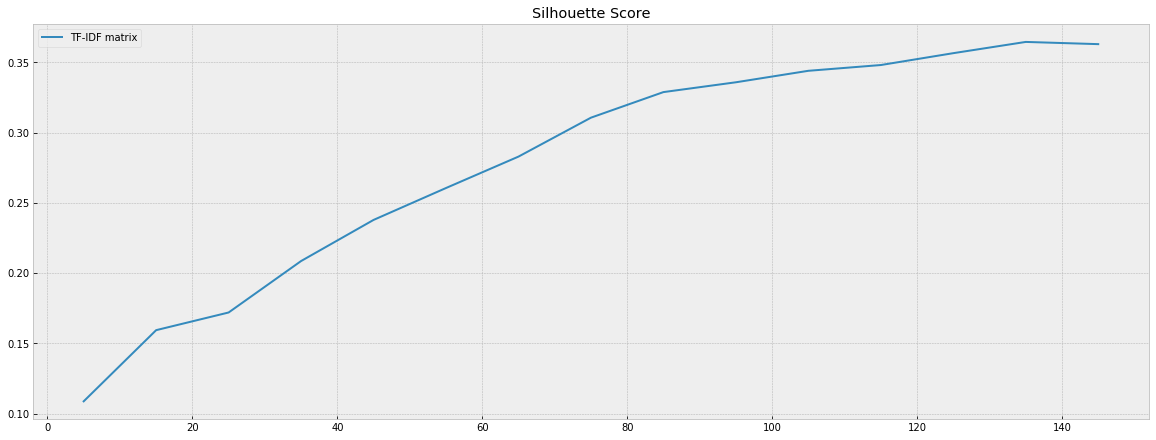

In [87]:
plt.figure(figsize=(20,16))

plt.subplot(2, 1, 1)
plt.plot(x, score_tfidf, label="TF-IDF matrix")
plt.title("Silhouette Score")
plt.legend()

Text(0.5, 1.0, '135 clusters')

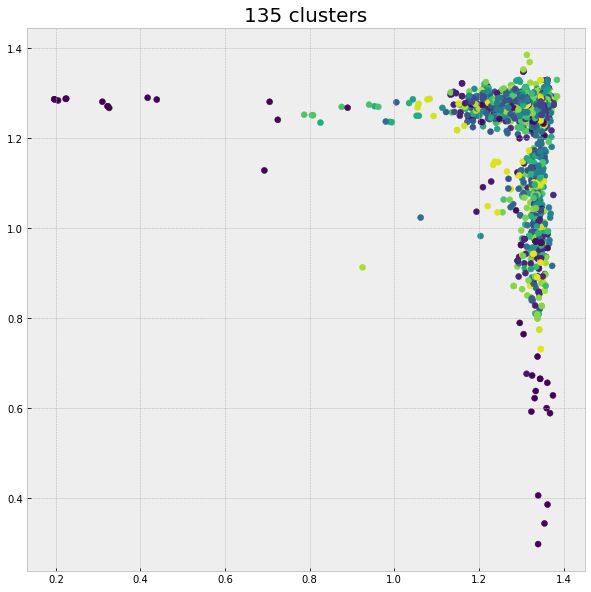

In [88]:
n_clusters = 135

kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30, random_state=0)
proj = kmeans.fit_transform(TF_IDF_embedded)
clusters = kmeans.predict(TF_IDF_embedded)
plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("135 clusters", fontsize="20")

Text(0.5, 1.0, 'TSNE')

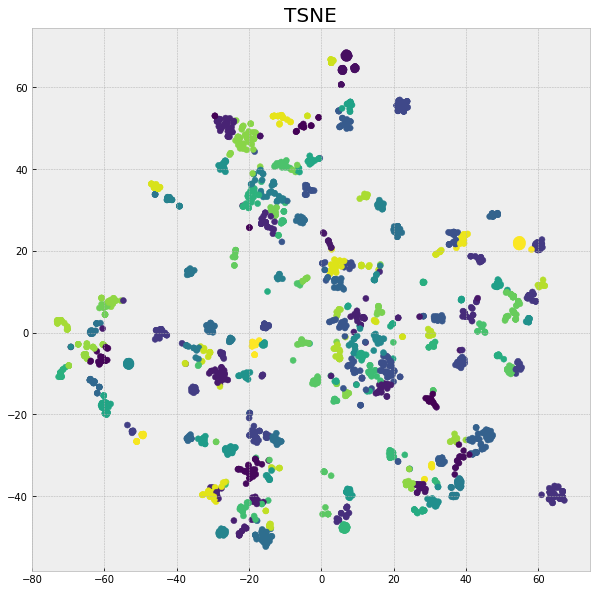

In [89]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(TF_IDF_embedded)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("TSNE", fontsize="20")

<Figure size 432x288 with 0 Axes>

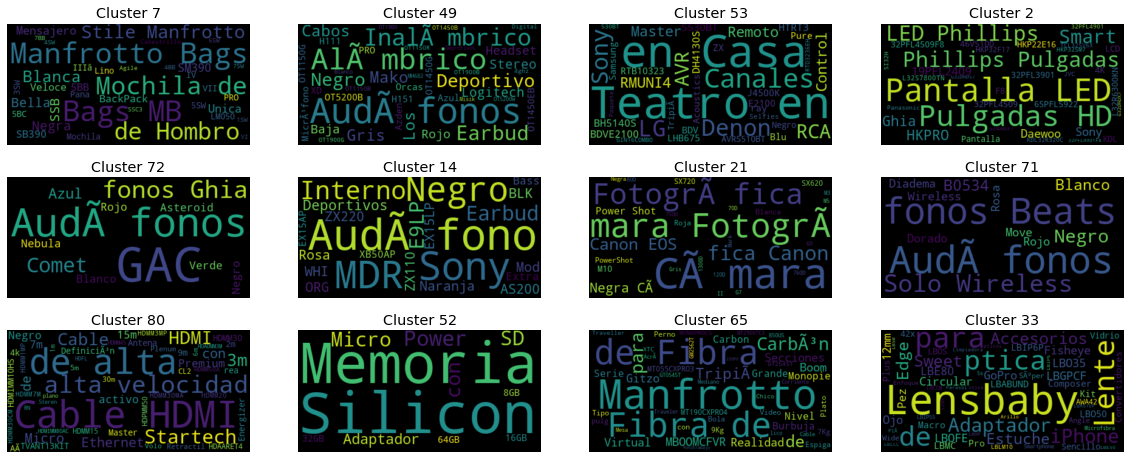

<Figure size 432x288 with 0 Axes>

In [90]:
plt.figure(figsize=(20,8))
wc = WordCloud()

for num, cluster in enumerate(random.sample(range(100), 12)) :
    plt.subplot(3, 4, num+1)
    wc.generate(" ".join(X[np.where(clusters==cluster)]))
    plt.imshow(wc, interpolation='bilinear')
    plt.title("Cluster {}".format(cluster))
    plt.axis("off")
plt.figure()

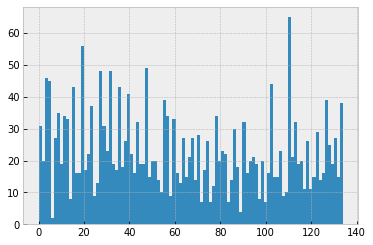

In [91]:
pd.Series(clusters).hist(bins=100)

In [92]:
dict_article_to_cluster = {article : cluster for article, cluster in zip(X, clusters)}

In [93]:
cluster = df_cleaned['Descripcion'].apply(lambda x : dict_article_to_cluster[x])
df2 = pd.get_dummies(cluster, prefix="Cluster").mul(df_cleaned["PrecioTotal"], 0)
df2 = pd.concat([df_cleaned['Factura'], df2], axis=1)
df2_grouped = df2.groupby('Factura').sum()

In [95]:
custom_aggregation = {}
custom_aggregation["PrecioTotal"] = lambda x:x.iloc[0]
custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequencia"] = lambda x:x.iloc[0]
custom_aggregation["Valor monterario"] = lambda x:x.iloc[0]
custom_aggregation["ClienteID"] = lambda x:x.iloc[0]
custom_aggregation["Cantidad"] = "sum"
custom_aggregation["Ciudad"] = lambda x:x.iloc[0]


df_grouped = df_cleaned.groupby("Factura").agg(custom_aggregation)

In [96]:
df2_grouped_final = pd.concat([df_grouped['ClienteID'], df2_grouped], axis=1).set_index("ClienteID").groupby("ClienteID").sum()
df2_grouped_final = df2_grouped_final.div(df2_grouped_final.sum(axis=1), axis=0)
df2_grouped_final = df2_grouped_final.fillna(0)

In [97]:
custom_aggregation = {}
custom_aggregation["PrecioTotal"] = ['min','max','mean']
custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequencia"] = lambda x:x.iloc[0]
custom_aggregation["Valor monterario"] = lambda x:x.iloc[0]
custom_aggregation["Cantidad"] = "sum"
custom_aggregation["Ciudad"] = lambda x:x.iloc[0]

df_grouped_final = df_grouped.groupby("ClienteID").agg(custom_aggregation)

In [98]:
df_grouped_final.head(5)

PrecioTotal                   min_recency max_recency frequencia  \
                  min    max       mean    <lambda>    <lambda>   <lambda>   
ClienteID                                                                    
12347            17.0  34.00  22.942857         2.0       367.0          7   
12348            17.0  41.76  32.786667       248.0       358.0          3   
12349            17.7  17.70  17.700000        18.0        18.0          1   
12350            25.2  25.20  25.200000       310.0       310.0          1   
12352             0.0  35.70  17.285714        36.0       296.0          7   

          Valor monterario Cantidad   Ciudad  
                  <lambda>      sum <lambda>  
ClienteID                                     
12347              3128.84     1700       32  
12348               857.24     1868       25  
12349              1009.93      418       17  
12350               276.70      190        6  
12352               962.93      360        6

In [99]:
df_grouped_final.columns = ["min", "max", "mean", "min_recency", "max_recency", "frequencia", "Valor monetario", "cantidad", "ciudad"]

In [100]:
df_grouped_final.head(5)

,min,max,mean,min_recency,max_recency,frequencia,Valor monetario,cantidad,ciudad
ClienteID,,,,,,,,,
12347,17.0,34.00,22.942857,2.0,367.0,7,3128.84,1700,32
12348,17.0,41.76,32.786667,248.0,358.0,3,857.24,1868,25
12349,17.7,17.70,17.700000,18.0,18.0,1,1009.93,418,17
12350,25.2,25.20,25.200000,310.0,310.0,1,276.70,190,6
12352,0.0,35.70,17.285714,36.0,296.0,7,962.93,360,6


In [101]:
X1 = df_grouped_final.as_matrix()
X2 = df2_grouped_final.as_matrix()

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X_final_std_scale = np.concatenate((X1, X2), axis=1)

In [102]:
x = list(range(2, 12))
y_std = []
for n_clusters in x:
    print("n_clusters =", n_clusters)
    
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X_final_std_scale)
    clusters = kmeans.predict(X_final_std_scale)
    silhouette_avg = silhouette_score(X_final_std_scale, clusters)
    y_std.append(silhouette_avg)
    print("silhouette_score es :", silhouette_avg, "with Std ")

n_clusters = 2
silhouette_score es : 0.8659278515302367 with Std 
n_clusters = 3
silhouette_score es : 0.8551062860438352 with Std 
n_clusters = 4
silhouette_score es : 0.4985082236977599 with Std 
n_clusters = 5
silhouette_score es : 0.3046399787645045 with Std 
n_clusters = 6
silhouette_score es : 0.3972881844964337 with Std 
n_clusters = 7
silhouette_score es : 0.4014706482596091 with Std 
n_clusters = 8
silhouette_score es : 0.41059323004856113 with Std 
n_clusters = 9
silhouette_score es : 0.41327255840449434 with Std 
n_clusters = 10
silhouette_score es : 0.40846248015143316 with Std 
n_clusters = 11
silhouette_score es : 0.3605670519657595 with Std 


In [103]:
kmeans = KMeans(init='k-means++', n_clusters = 8, n_init=30, random_state=0)  # random state just to be able to provide cluster number durint analysis
kmeans.fit(X_final_std_scale)
clusters = kmeans.predict(X_final_std_scale)

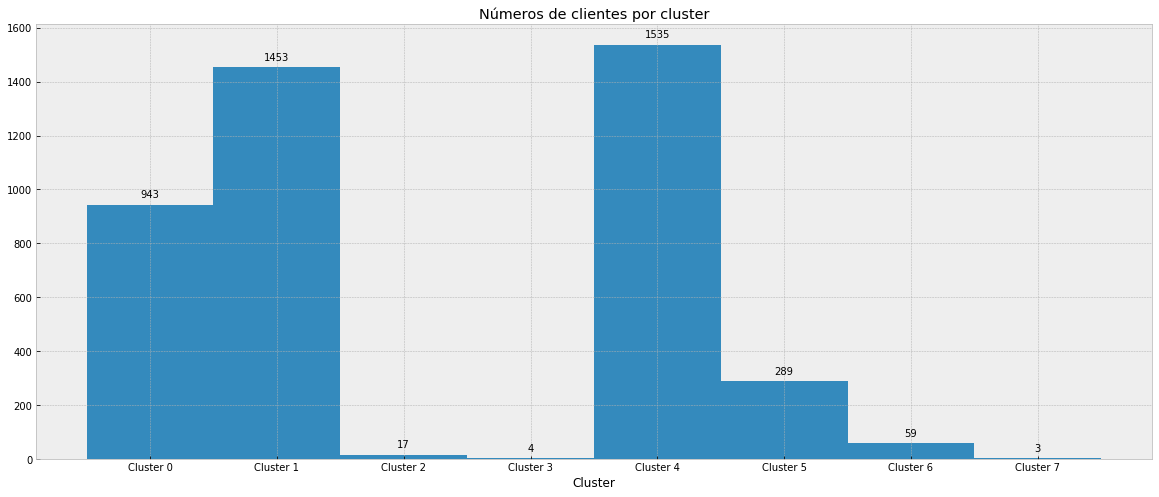

In [104]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(clusters, bins=8)
plt.xlabel("Cluster")
plt.title("Números de clientes por cluster")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Cluster {}".format(x) for x in range(8)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [105]:
df_grouped_final["cluster"] = clusters

In [106]:
final_dataset = pd.concat([df_grouped_final, df2_grouped_final], axis = 1)
final_dataset.head()

,min,max,mean,min_recency,max_recency,frequencia,Valor monetario,cantidad,ciudad,cluster,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
ClienteID,,,,,,,,,,,,,,,,,,,,,
12347,17.0,34.00,22.942857,2.0,367.0,7,3128.84,1700,32,5,...,0.0,0.000000,0.011410,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000
12348,17.0,41.76,32.786667,248.0,358.0,3,857.24,1868,25,5,...,0.0,0.000000,0.081191,0.000000,0.0,0.0,0.0,0.00000,0.047595,0.000000
12349,17.7,17.70,17.700000,18.0,18.0,1,1009.93,418,17,5,...,0.0,0.000000,0.000000,0.049013,0.0,0.0,0.0,0.00000,0.000000,0.000000
12350,25.2,25.20,25.200000,310.0,310.0,1,276.70,190,6,0,...,0.0,0.036863,0.073726,0.000000,0.0,0.0,0.0,0.05421,0.000000,0.000000
12352,0.0,35.70,17.285714,36.0,296.0,7,962.93,360,6,4,...,0.0,0.000000,0.000000,0.015577,0.0,0.0,0.0,0.01807,0.000000,0.015577


In [107]:
final_dataset_V2 = final_dataset.reset_index()

In [108]:
final_dataset_V2.to_csv("final_dataset_V2.csv",index=False)


In [109]:
with open('df_cleaned.pickle', 'wb') as f:
    pickle.dump(df_cleaned, f)

Text(0.5, 1.0, 'Visualización de los clusters con TSNE')

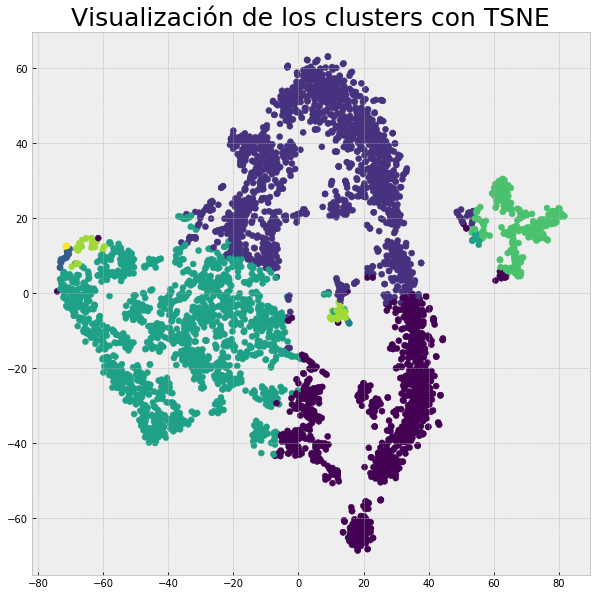

In [110]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(X_final_std_scale)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualización de los clusters con TSNE", fontsize="25")

In [111]:
final_dataset[final_dataset['cluster']==0]

,min,max,mean,min_recency,max_recency,frequencia,Valor monetario,cantidad,ciudad,cluster,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
ClienteID,,,,,,,,,,,,,,,,,,,,,
12350,25.20,25.20,25.200000,310.0,310.0,1,276.70,190,6,0,...,0.000000,0.036863,0.073726,0.000000,0.000000,0.000000,0.000000,0.054210,0.000000,0.000000
12361,23.40,23.40,23.400000,287.0,287.0,1,174.90,90,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12377,19.80,79.20,49.500000,315.0,354.0,2,1453.14,880,13,0,...,0.000000,0.000000,0.000000,0.030967,0.000000,0.000000,0.000000,0.030967,0.000000,0.000000
12383,5.04,34.00,20.480000,184.0,352.0,5,1492.41,1385,0,0,...,0.000000,0.000000,0.000000,0.003377,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12386,30.00,68.00,49.000000,337.0,366.0,2,401.90,354,12,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12401,17.85,17.85,17.850000,303.0,303.0,1,54.30,6,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12402,19.50,19.50,19.500000,323.0,323.0,1,177.90,86,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12410,17.00,17.00,17.000000,308.0,308.0,2,497.93,195,13,0,...,0.060249,0.000000,0.034945,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12422,16.50,17.70,17.100000,168.0,324.0,2,488.10,237,12,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036263,0.000000,0.036263


In [112]:
final_dataset[final_dataset['cluster']==0].mean()

min                 23.131676
max                 34.545154
mean                28.370456
min_recency        252.556734
max_recency        282.793213
frequencia           1.601273
Valor monetario    392.180170
cantidad           218.792153
ciudad               1.235419
cluster              0.000000
Cluster_0            0.003421
Cluster_1            0.004769
Cluster_2            0.029295
Cluster_3            0.014917
Cluster_4            0.004451
Cluster_5            0.006543
Cluster_6            0.001353
Cluster_7            0.003825
Cluster_8            0.003531
Cluster_9            0.016541
Cluster_10           0.003308
Cluster_11           0.006987
Cluster_12           0.002171
Cluster_13           0.007801
Cluster_14           0.003193
Cluster_15           0.007788
Cluster_16           0.009206
Cluster_17           0.010844
Cluster_18           0.016588
Cluster_19           0.014287
                      ...    
Cluster_105          0.012681
Cluster_106          0.004057
Cluster_10

In [113]:
temp_final_df = final_dataset.reset_index()

In [114]:
cust0 = list(temp_final_df[temp_final_df['cluster']==0]['ClienteID'])

In [117]:
cluster0 = df_cleaned[df_cleaned['ClienteID'].isin(cust0)]
cluster0[['Cantidad', 'PrecioUnitario', 'CantidadCancelada', 'PrecioTotal', 'frequencia', 'min_recency'
         , 'Valor monterario']].mean()

Cantidad               8.611779
PrecioUnitario         3.336076
CantidadCancelada      0.124718
PrecioTotal           15.436426
frequencia             2.629852
min_recency          243.051298
Valor monterario     766.800176
dtype: float64

In [118]:
cluster0['Descripcion'].value_counts()[:10]

Pantalla LCD Sony 46 Pulgadas HD KDL-46V5100                          220
CÃ¡mara FotogrÃ¡fica Nikon D7200 Negra                                186
Cable 30cm USB B H a M Panel Startech USBPNLBFBM1                     141
Soporte Movible Power & Co - MT1040                                   122
Nikon CÃ¡mara Reflex D7200 con AF-S DX Nikkor                         103
BastÃ³n para CÃ¡maras Xsories USHM4A004 - Azul                        100
Estuche para CÃ¡mara Blanco Nano V Stile Manfrotto Bags MB SCP-5SW    100
Pantalla LED Sharp 50 Pulgadas 4K LC50N6000U                           99
Pantalla LED Sharp 60 Pulgadas 4K LC60N7000U                           95
Drone AW-QDR-LHS                                                       83
Name: Descripcion, dtype: int64

In [119]:
custom_aggregation = {}
custom_aggregation["Ciudad"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]

cluster0_grouped = cluster0.groupby("ClienteID").agg(custom_aggregation)

In [120]:
cluster0_grouped['RFMScore'].value_counts()

444    341
443    221
433     90
432     69
442     48
422     41
434     37
423     27
411     12
421     10
431      9
424      8
441      8
412      7
333      5
413      3
321      3
322      2
334      1
323      1
Name: RFMScore, dtype: int64

In [121]:
cluster0_grouped['Ciudad'].value_counts()

1     910
4       6
0       6
13      4
17      3
3       3
12      2
10      2
19      1
15      1
14      1
11      1
8       1
6       1
2       1
Name: Ciudad, dtype: int64

In [122]:
cluster0['Mes'].value_counts()

12    5152
3     3874
4     3096
2     3079
1     3019
5     2870
6     2310
7      556
8        2
Name: Mes, dtype: int64

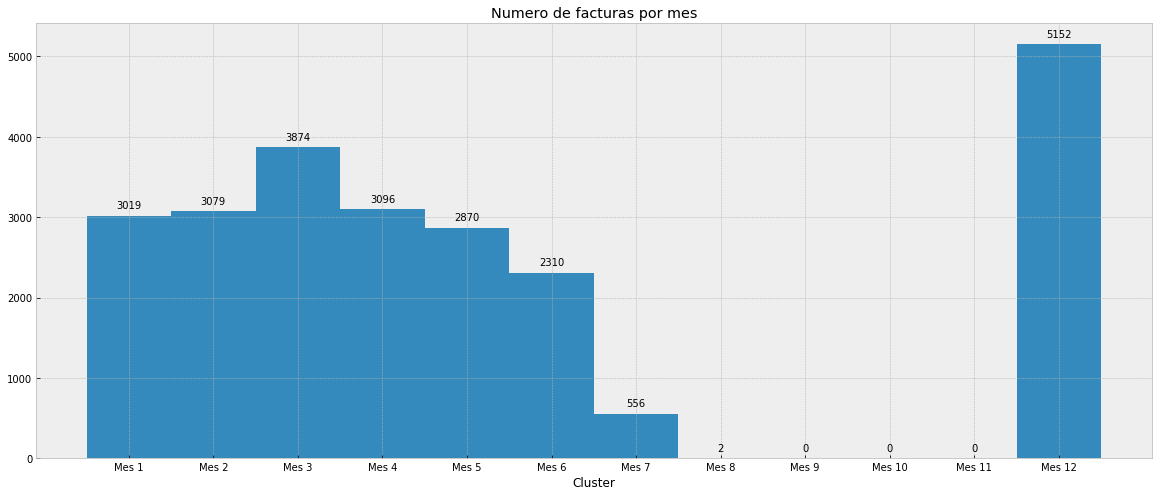

In [123]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Mes'], bins=12)
plt.xlabel("Cluster")
plt.title("Numero de facturas por mes")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Mes {}".format(x) for x in range(1, 13)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [124]:
temp['Año'] = cluster0[cluster0['Mes']==12]['FechaFacturacion'].map(lambda x: x.year)
temp['Año'].value_counts()

2010.0    709
Name: Año, dtype: int64

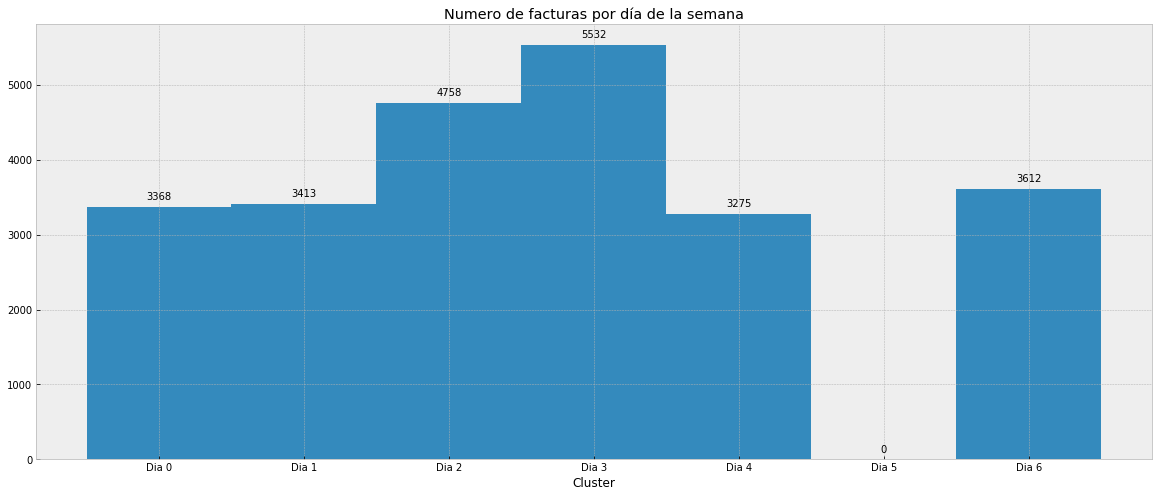

In [125]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['DiaSemana'], bins=7)
plt.xlabel("Cluster")
plt.title("Numero de facturas por día de la semana")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Dia {}".format(x) for x in range(0, 7)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [126]:
cluster0['Dia'].nunique()

31

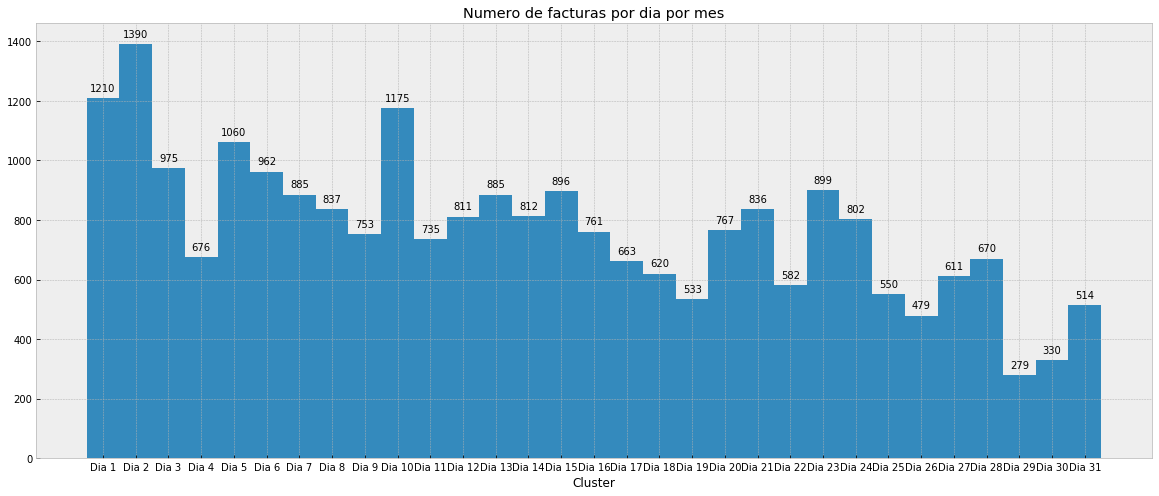

In [127]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Dia'], bins=31)
plt.xlabel("Cluster")
plt.title("Numero de facturas por dia por mes")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Dia {}".format(x) for x in range(1,32)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import datetime as dt
import pickle
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [129]:
new_df = pd.read_csv("final_dataset_V2.csv")

In [130]:
new_df.head(5)

,ClienteID,min,max,mean,min_recency,max_recency,frequencia,Valor monetario,cantidad,ciudad,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
0,12347,17.0,34.00,22.942857,2.0,367.0,7,3128.84,1700,32,...,0.0,0.000000,0.011410,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000
1,12348,17.0,41.76,32.786667,248.0,358.0,3,857.24,1868,25,...,0.0,0.000000,0.081191,0.000000,0.0,0.0,0.0,0.00000,0.047595,0.000000
2,12349,17.7,17.70,17.700000,18.0,18.0,1,1009.93,418,17,...,0.0,0.000000,0.000000,0.049013,0.0,0.0,0.0,0.00000,0.000000,0.000000
3,12350,25.2,25.20,25.200000,310.0,310.0,1,276.70,190,6,...,0.0,0.036863,0.073726,0.000000,0.0,0.0,0.0,0.05421,0.000000,0.000000
4,12352,0.0,35.70,17.285714,36.0,296.0,7,962.93,360,6,...,0.0,0.000000,0.000000,0.015577,0.0,0.0,0.0,0.01807,0.000000,0.015577


In [131]:
X = new_df.drop(columns=['ClienteID', 'cluster']) 
y = new_df['cluster'].values

In [134]:
scaler = StandardScaler() # create scaler object

X_scaled = scaler.fit_transform(X)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size = 0.2,random_state = 0, stratify=y)

In [138]:
!pip install xgboost

  Using cached https://files.pythonhosted.org/packages/96/84/4e2cae6247f397f83d8adc5c2a2a0c5d7d790a14a4c7400ff6574586f589/xgboost-0.90.tar.gz
  Stored in directory: /Users/FERNANDOC./Library/Caches/pip/wheels/e9/48/4d/de4187b5270dff71d3697c5a7857a1e2d9a0c63a28b3462eeb
Successfully built xgboost


In [139]:
import xgboost

In [140]:
xgb = xgboost.XGBClassifier(random_state = 0, learning_rate = 0.01, 
                                   objective = 'multi:softprob', n_estimators = 1000,
                                  colsample_bytree = 0.6, gamma = 0.5, max_depth = 7,
                                  min_child_weight = 1, subsample=0.8, n_jobs=-1, scoring='accuracy')

In [141]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.5,
              learning_rate=0.01, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, scoring='accuracy',
              seed=None, silent=None, subsample=0.8, verbosity=1)

In [142]:
print("Exactitud: ", (xgb.score(X_test, y_test))*100)

Exactitud:  98.72241579558653


In [143]:
y_pred = xgb.predict(X_test)

In [150]:
with open('modelo_elektra.pickle', 'wb') as f:
    pickle.dump(xgb, f)

In [152]:
predictions = pd.Series(y_pred) 

In [153]:
predictions.unique()

array([1, 4, 0, 6, 5, 2])

In [154]:
new_df.cluster.unique()

array([5, 0, 4, 1, 2, 6, 3, 7])